In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [2]:
x = np.random.normal(0,1,100000)

(array([1.3000e+01, 2.8100e+02, 2.6910e+03, 1.1847e+04, 2.7648e+04,
        3.2186e+04, 1.8884e+04, 5.5810e+03, 8.0500e+02, 6.4000e+01]),
 array([-4.44027271, -3.59002761, -2.73978252, -1.88953742, -1.03929232,
        -0.18904723,  0.66119787,  1.51144296,  2.36168806,  3.21193316,
         4.06217825]),
 <a list of 10 Patch objects>)

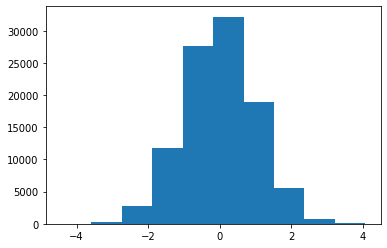

In [3]:
plt.hist(x)

In [4]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
import tensorflow as tf

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

In [5]:
'''
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput
'''

'\ndef myloss(y_true, y_pred, alpha = 0.):\n    #alpha determines the amount of decorrelation; 0 means no decorrelation.\n    \n    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.\n    #g(x) = y_pred[:,0]\n    #f(g(x)) = y_pred[:,1]\n    #h(x) = y_pred[:,2]\n    #h(g(x)) = y_pred[:,3]\n    \n    myoutput =  mse(y_true[:,0],y_pred[:,1])                 - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2]))                 - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))\n    return myoutput\n'

In [6]:
'''
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
#autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []
preds += [encoder.predict(np.linspace(-4,4,10))]

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)))

    #y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    #print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True
'''

'\n#setup the model\n\nmyinput = Input(shape=(1,))\nencoded = Dense(5, activation=\'elu\')(myinput)\nencoded = Dense(5, activation=\'elu\')(encoded)\nencoded = Dense(1, activation=\'linear\')(encoded)\n\nencoder = Model(myinput, encoded)\nencoder2 = encoder(encoder(myinput))\nautoencoder = Model(myinput, encoder2)\n\ncombinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))\n\nmyinput_classify = Input(shape=(1,))\nmyclassifier = Dense(128, activation=\'elu\')(myinput_classify)\nmyclassifier = Dense(64, activation=\'elu\')(myclassifier)\nmyclassifier = Dense(1, activation=\'sigmoid\')(myclassifier)\nmyclassifier_model = Model(myinput_classify, myclassifier)\nmyclassifier_input = myclassifier_model(myinput)\nmyclassifier_encoded = myclassifier_model(encoded)\n\ncombinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))\n\n#First, pretrain the autoencoder:\n#autoencoder.compile(optimizer=\'adam\', loss=\'mse

In [7]:
'''
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)
'''

'\nfor i in range(len(preds)):\n    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))\n    pass\nplt.legend(frameon=False)\n'

In [8]:
#mypreds = combinedModel_classifier.predict(x)

In [9]:
'''
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("function value")
plt.legend(frameon=False)
'''

'\nplt.scatter(x,mypreds[:,0],label="Encoder")\nplt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")\nplt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=\':\',color="gray")\nplt.xlabel("x")\nplt.ylabel("function value")\nplt.legend(frameon=False)\n'

In [10]:
x2 = np.random.normal(0,1,100000)

In [11]:
X = np.c_[x,x2]

In [12]:
def myloss2d(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [13]:
#setup the model

myinput_2d = Input(shape=(2,))
encoded_2d = Dense(5, activation='elu')(myinput_2d)
encoded_2d = Dense(5, activation='elu')(encoded_2d)
encoded_2d = Dense(2, activation='linear')(encoded_2d)

encoder_2d = Model(myinput_2d, encoded_2d)
encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
autoencoder_2d = Model(myinput_2d, encoder2_2d)

combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

myinput_classify_2d = Input(shape=(2,))
myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

preds = []
preds += [encoder_2d.predict(X)]

for i in range(20):
    print("on i=",i)
    #Now, train the classifier
    encoded_x_2d = encoder_2d.predict(X)
    myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))
    
    #Now, update the autoencoder
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = False

    combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
    combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))
    
    autoencoder_2d.compile(optimizer='adam', loss='mse')
    autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))
    
    preds += [encoder_2d.predict(X)]
    
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = True

on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 6us/step - loss: 0.3696
Epoch 1/1
100000/100000 [==============================] - 1s 11us/step - loss: -1.4472
Epoch 1/5
100000/100000 [==============================] - 1s 7us/step - loss: 0.7194
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.5608
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.3574
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1220
Epoch 5/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.1003
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 1.3139
Epoch 1/1
100000/100000 [==============================] - 1s 11us/step - loss: -1.8347
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 0.8314
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1102
Epoch 3/5
100000/100000 [=========

100000/100000 [==============================] - 3s 31us/step - loss: 48.0417
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 3.1105
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.6310
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4768
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4112
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 19us/step - loss: 0.3295
Epoch 1/1
100000/100000 [==============================] - 4s 37us/step - loss: -9.8666
Epoch 1/5
100000/100000 [==============================] - 3s 34us/step - loss: 61.2589
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 3.9547
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.8645
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.6429
Epoch 5/5
100000/100000 [=======================

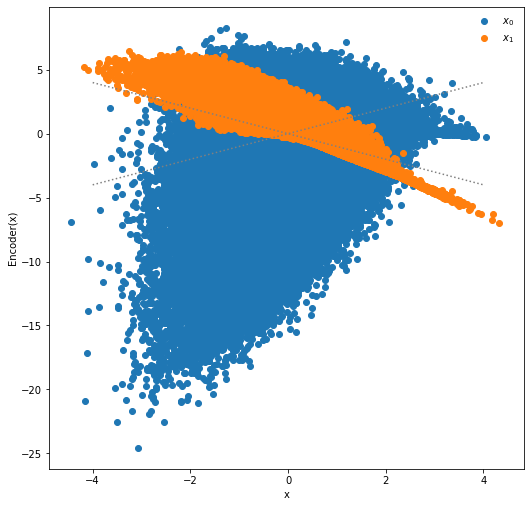

In [14]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,0],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,1],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [15]:
mypreds = combinedModel_classifier_2d.predict(X)

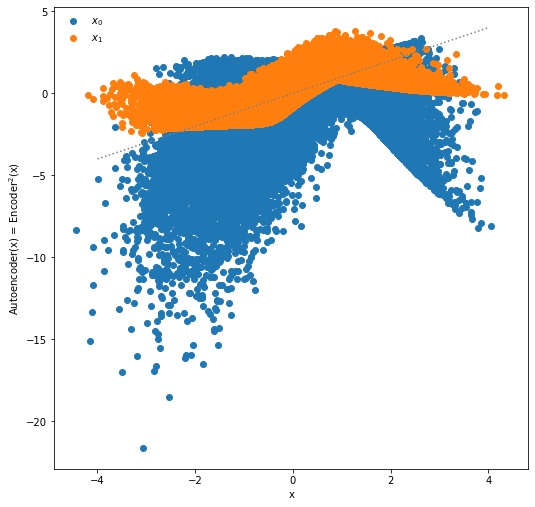

In [16]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

In [ ]:
for k in range(100):
    
    print("on k=",k)

    K.clear_session()

    #setup the model

    myinput_2d = Input(shape=(2,))
    encoded_2d = Dense(5, activation='elu')(myinput_2d)
    encoded_2d = Dense(5, activation='elu')(encoded_2d)
    encoded_2d = Dense(2, activation='linear')(encoded_2d)

    encoder_2d = Model(myinput_2d, encoded_2d)
    encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
    autoencoder_2d = Model(myinput_2d, encoder2_2d)

    combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

    myinput_classify_2d = Input(shape=(2,))
    myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
    myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
    myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
    myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
    myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
    myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

    combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

    preds = []
    preds += [encoder_2d.predict(X)]

    for i in range(20):
        print("on i=",i)
        #Now, train the classifier
        encoded_x_2d = encoder_2d.predict(X)
        myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
        myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))

        #Now, update the autoencoder
        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = False

        combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
        combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))

        autoencoder_2d.compile(optimizer='adam', loss='mse')
        autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))

        preds += [encoder_2d.predict(X)]

        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = True

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],preds[-1][:,0][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],preds[-1][:,1][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Encoder(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/encoder_"+str(k)+".pdf",bbox_inches='tight')

    mypreds = combinedModel_classifier_2d.predict(X)
    
    print("why is this growing?",len(X),len(mypreds))

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],mypreds[:,2][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],mypreds[:,3][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/autoencoder_"+str(k)+".pdf",bbox_inches='tight')

on k= 0
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 6us/step - loss: 0.4180
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.4437
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.4710
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0753
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0499
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0402
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0353
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3670
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9185
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.5272
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0437
Epoch 3/5
100000/100000 [

100000/100000 [==============================] - 4s 35us/step - loss: 42.1787
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 5.2538
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.3435
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4326
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2608
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3176
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -10.1803
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 62.4225
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 7.7319
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.0918
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.7056
Epoch 5/5
100000/100000 [======================

100000/100000 [==============================] - 1s 5us/step - loss: 0.1272
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0312
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0282
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0269
on i= 7
Epoch 1/1
200000/200000 [==============================] - 3s 14us/step - loss: 0.5708
Epoch 1/1
100000/100000 [==============================] - 3s 27us/step - loss: -2.6945
Epoch 1/5
100000/100000 [==============================] - 2s 23us/step - loss: 2.6024
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1485
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0367
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0324
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0306
on i= 8
Epoch 1/1
200000/200000 [===================

100000/100000 [==============================] - 1s 5us/step - loss: 0.1370
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1282
why is this growing? 100000 100000
on k= 2
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5007
Epoch 1/1
100000/100000 [==============================] - 1s 12us/step - loss: -2.4335
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 0.8664
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1522
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0888
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0713
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0606
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.8334
Epoch 1/1
100000/100000 [==============================] - 1s 12us/step - loss: -2.0179
E

200000/200000 [==============================] - 3s 17us/step - loss: 0.5013
Epoch 1/1
100000/100000 [==============================] - 4s 36us/step - loss: -5.1751
Epoch 1/5
100000/100000 [==============================] - 3s 32us/step - loss: 4.3096
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1076
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0726
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0634
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0562
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 19us/step - loss: 0.4571
Epoch 1/1
100000/100000 [==============================] - 4s 37us/step - loss: -5.8877
Epoch 1/5
100000/100000 [==============================] - 3s 34us/step - loss: 5.4516
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1197
Epoch 3/5
100000/100000 [======================

Epoch 1/5
100000/100000 [==============================] - 2s 16us/step - loss: 2.7125
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1508
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0748
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0702
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0668
on i= 7
Epoch 1/1
200000/200000 [==============================] - 2s 11us/step - loss: 0.5713
Epoch 1/1
100000/100000 [==============================] - 2s 22us/step - loss: -2.8289
Epoch 1/5
100000/100000 [==============================] - 2s 18us/step - loss: 3.5945
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1835
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0766
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0721
Epoch 5/5
100000/100000 [================

100000/100000 [==============================] - 1s 6us/step - loss: 1.1088
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7551
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5963
why is this growing? 100000 100000
on k= 4
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4119
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.8077
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 1.4072
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.6041
Epoch 3/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.2769
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1354
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1083
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.9829
Epo

100000/100000 [==============================] - 1s 6us/step - loss: 0.1914
on i= 13
Epoch 1/1
200000/200000 [==============================] - 4s 18us/step - loss: 0.2293
Epoch 1/1
100000/100000 [==============================] - 4s 35us/step - loss: -11.5876
Epoch 1/5
100000/100000 [==============================] - 3s 32us/step - loss: 63.9633
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.2654
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3821
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2372
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2207
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.2103
Epoch 1/1
100000/100000 [==============================] - 4s 38us/step - loss: -12.2601
Epoch 1/5
100000/100000 [==============================] - 3s 35us/step - loss: 74.7281
Epoch 2/5
100000/100000 [=========

200000/200000 [==============================] - 3s 14us/step - loss: 0.6495
Epoch 1/1
100000/100000 [==============================] - 3s 26us/step - loss: -2.1175
Epoch 1/5
100000/100000 [==============================] - 2s 22us/step - loss: 0.5521
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0348
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0273
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0244
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0224
on i= 7
Epoch 1/1
200000/200000 [==============================] - 3s 14us/step - loss: 0.6389
Epoch 1/1
100000/100000 [==============================] - 3s 27us/step - loss: -2.1938
Epoch 1/5
100000/100000 [==============================] - 2s 24us/step - loss: 0.6501
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0407
Epoch 3/5
100000/100000 [=======================

100000/100000 [==============================] - 5s 53us/step - loss: 39.0856
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3786
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2610
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2405
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2258
why is this growing? 100000 100000
on k= 6
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4074
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6689
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7787
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1507
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1065
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0833
Epoch 5/5

100000/100000 [==============================] - 1s 6us/step - loss: 0.0856
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0767
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0696
on i= 13
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.4363
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -4.0342
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 5.8122
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4459
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0797
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0681
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0618
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.5013
Epoch 1/1
100000/100000 [================

Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2658
on i= 6
Epoch 1/1
200000/200000 [==============================] - 3s 13us/step - loss: 0.5623
Epoch 1/1
100000/100000 [==============================] - 3s 26us/step - loss: -4.2547
Epoch 1/5
100000/100000 [==============================] - 2s 22us/step - loss: 9.6825
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.2067
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4832
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3738
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3412
on i= 7
Epoch 1/1
200000/200000 [==============================] - 3s 14us/step - loss: 0.5341
Epoch 1/1
100000/100000 [==============================] - 3s 27us/step - loss: -4.6926
Epoch 1/5
100000/100000 [==============================] - 2s 24us/step - loss: 12.1302
Epoch 2/5
100000/100000 [====

200000/200000 [==============================] - 6s 29us/step - loss: 0.3658
Epoch 1/1
100000/100000 [==============================] - 6s 59us/step - loss: -82.9997
Epoch 1/5
100000/100000 [==============================] - 5s 54us/step - loss: 7047.4476
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 874.1717
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 247.6556
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 98.3927
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 47.7698
why is this growing? 100000 100000
on k= 8
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3831
Epoch 1/1
100000/100000 [==============================] - 1s 12us/step - loss: -0.7567
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 0.9601
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.48

100000/100000 [==============================] - 3s 33us/step - loss: -9.8567
Epoch 1/5
100000/100000 [==============================] - 3s 29us/step - loss: 35.4852
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.7844
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4076
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3686
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3466
on i= 13
Epoch 1/1
200000/200000 [==============================] - 4s 18us/step - loss: 0.3175
Epoch 1/1
100000/100000 [==============================] - 3s 35us/step - loss: -11.5805
Epoch 1/5
100000/100000 [==============================] - 3s 32us/step - loss: 58.9406
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.3077
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7259
Epoch 4/5
100000/100000 [====================

100000/100000 [==============================] - 2s 16us/step - loss: 4.0673
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2534
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0686
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0541
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0478
on i= 6
Epoch 1/1
200000/200000 [==============================] - 2s 11us/step - loss: 0.5028
Epoch 1/1
100000/100000 [==============================] - 2s 22us/step - loss: -3.9965
Epoch 1/5
100000/100000 [==============================] - 2s 18us/step - loss: 5.1679
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3369
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0854
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0659
Epoch 5/5
100000/100000 [==========================

100000/100000 [==============================] - 1s 6us/step - loss: 0.9934
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5203
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3827
on i= 19
Epoch 1/1
200000/200000 [==============================] - 6s 28us/step - loss: 0.0215
Epoch 1/1
100000/100000 [==============================] - 6s 56us/step - loss: -21.9707
Epoch 1/5
100000/100000 [==============================] - 5s 52us/step - loss: 98.7337
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 6.5465
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0411
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5474
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4000
why is this growing? 100000 100000
on k= 10
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.41

Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5208
on i= 12
Epoch 1/1
200000/200000 [==============================] - 4s 19us/step - loss: 0.5623
Epoch 1/1
100000/100000 [==============================] - 4s 36us/step - loss: -10.9165
Epoch 1/5
100000/100000 [==============================] - 3s 32us/step - loss: 69.7145
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 6.4141
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.7362
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9682
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7354
on i= 13
Epoch 1/1
200000/200000 [==============================] - 4s 19us/step - loss: 0.5606
Epoch 1/1
100000/100000 [==============================] - 4s 38us/step - loss: -13.2107
Epoch 1/5
100000/100000 [==============================] - 3s 35us/step - loss: 104.9294
Epoch 2/5
100000/100000

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 11
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3677
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6660
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.0921
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3026
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1042
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0780
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0621
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.4084
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.8661
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 2.0354
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1608
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 140.3031
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 6.3664
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 3.1934
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.5335
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.1721
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.1111
Epoch 1/1
100000/100000 [==============================] - 4s 40us/step - loss: -26.0785
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 187.7949
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 8.6386
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.1364
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.2844
Epoch 5/5
100000/100000 [====================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 12
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4133
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.5601
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.8994
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3150
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1344
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1032
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0784
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2663
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -0.2432
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.9108
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1353
Epoch 3/5
100000/100000

Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 789.2929
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 85.5772
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 25.0090
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 11.7874
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.3257
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.3218
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -47.6020
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 1273.0462
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 143.6297
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 43.2171
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 20.7748
Epoch 5/5
100000/100000 [==

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 13
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3964
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -0.2500
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7776
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.5406
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.5132
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.3144
Epoch 5/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.0602
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.5742
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.2879
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.8154
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1913
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 34us/step - loss: 17.9815
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.8124
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2961
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2476
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2265
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2077
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: 7.2036
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 13.2128
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7128
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2931
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2400
Epoch 5/5
100000/100000 [========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 14
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4320
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.3023
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6438
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2359
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0793
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0651
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0581
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1453
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.7998
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.2268
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0567
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 34us/step - loss: 8.3008
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3893
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0554
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0434
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0384
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.3056
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -6.8232
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 9.8757
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3114
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0568
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0464
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 15
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4642
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.4027
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9422
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2555
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0871
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0658
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0570
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.9596
Epoch 1/1
100000/100000 [==============================] - 3s 31us/step - loss: -2.0349
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.7880
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0836
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 34us/step - loss: 783.7639
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 67.4867
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 12.2530
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.3122
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.4973
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2448
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -30.9465
Epoch 1/5
100000/100000 [==============================] - 4s 36us/step - loss: 1081.9764
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 91.5679
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 17.0268
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 6.4983
Epoch 5/5
100000/100000 [===============

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 16
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5313
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.7569
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5847
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1619
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1146
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0922
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0778
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7891
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9607
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.8864
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0938
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 1.0556
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0267
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0212
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0192
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0178
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.4318
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -2.3301
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 1.4725
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0336
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0205
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0192
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 17
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5969
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.5275
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7271
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1430
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0931
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0845
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0771
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.6679
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.6086
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 1.8052
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1738
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 48.2202
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.5254
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2336
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1704
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1601
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.1850
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -7.4253
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 62.8613
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.3275
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2747
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1852
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 18
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4859
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.4151
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.3246
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2794
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1569
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1325
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1194
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.8218
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -3.3829
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 8.0133
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.7219
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 104.4731
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 8.3900
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0377
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3941
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3233
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2529
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -11.3298
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 141.4093
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 10.0570
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0048
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4818
Epoch 5/5
100000/100000 [===================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 19
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3936
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.9921
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9836
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1954
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1119
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0928
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0790
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1632
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.1569
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.0305
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1101
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 5.4929
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1141
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0519
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0430
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0383
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.4770
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -5.4858
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 6.5239
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1412
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0678
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0532
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 20
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3561
Epoch 1/1
100000/100000 [==============================] - 1s 12us/step - loss: -1.6387
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 0.9921
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3530
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1373
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0893
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0780
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 1.4754
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -2.7094
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 3.6366
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3504
Epoch 3/5
100000/100000 [

100000/100000 [==============================] - 3s 32us/step - loss: 233.9707
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 19.1226
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.7052
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.4630
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.2527
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.2913
Epoch 1/1
100000/100000 [==============================] - 4s 39us/step - loss: -12.7386
Epoch 1/5
100000/100000 [==============================] - 3s 35us/step - loss: 328.4504
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 25.8084
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.6731
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.2026
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 21
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3922
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.2135
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5709
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1766
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0457
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0411
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0372
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.7283
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.0270
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.4897
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0397
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 11.8499
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4230
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0491
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0463
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0436
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.2944
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -7.0848
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 14.8603
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5586
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0533
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0500
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 22
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4419
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.4595
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 1.1105
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.4471
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1824
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1134
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0924
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1394
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.4359
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4283
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0642
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 5.9702
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5091
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0994
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0486
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0425
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.6744
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -5.1265
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 8.7789
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.7713
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1841
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0900
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 23
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3856
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6856
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2459
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3580
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1599
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1294
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1130
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3269
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.1145
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7278
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1102
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 2.5496
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0602
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0513
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0452
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0407
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.3417
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -3.7071
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 2.6621
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0603
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0510
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0446
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 24
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5368
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.4538
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.4454
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1160
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0911
Epoch 4/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.0739
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0612
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7664
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9324
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4650
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0677
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 14.9838
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4091
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0746
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0624
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0552
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3506
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -7.6070
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 18.3118
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4725
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0858
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0719
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 25
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3765
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.9799
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.3647
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1196
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0853
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0676
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0578
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.7619
Epoch 1/1
100000/100000 [==============================] - 2s 15us/step - loss: -1.8488
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.4548
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0624
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 34us/step - loss: 21.0069
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2558
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1156
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1093
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1030
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3163
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -8.1771
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 31.2037
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3519
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1383
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1315
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 26
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3564
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.0702
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7856
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1089
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0590
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0517
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0457
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.6268
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.4033
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.8397
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0715
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 40us/step - loss: 34.6871
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.8262
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2312
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1833
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1586
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 24us/step - loss: 0.3111
Epoch 1/1
100000/100000 [==============================] - 5s 47us/step - loss: -7.4355
Epoch 1/5
100000/100000 [==============================] - 4s 43us/step - loss: 46.6818
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.4372
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3545
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2831
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 27
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4029
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -2.5055
Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 1.7821
Epoch 2/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.5764
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2246
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1623
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1458
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 1.2759
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.5944
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.4595
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2076
Epoch 3/5
100000/100000 [

100000/100000 [==============================] - 4s 35us/step - loss: 23.5031
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.2371
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1133
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0986
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0934
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2509
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -10.8559
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 25.7238
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.2463
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1489
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1311
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 28
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4345
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.5800
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2218
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3595
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0777
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0620
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0567
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3422
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.6722
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 2.1342
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1966
Epoch 3/5
100000/100000 

Epoch 1/5
100000/100000 [==============================] - 4s 36us/step - loss: 399.5398
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 45.5900
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 11.5292
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.3040
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.5150
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3180
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -22.0239
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 501.6168
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 57.2347
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 14.8253
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.0203
Epoch 5/5
100000/100000 [======

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 29
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3293
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.2949
Epoch 1/5
100000/100000 [==============================] - 3s 26us/step - loss: 0.7920
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4205
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1803
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1185
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0981
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 1.5196
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.8461
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.5128
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0975
Epoch 3/5
100000/100000

100000/100000 [==============================] - 3s 34us/step - loss: 5.1754
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2891
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1116
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0785
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0665
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.6618
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -5.1725
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 6.8913
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3965
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1398
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0934
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 30
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5095
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: 0.7779
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6090
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1978
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1139
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0900
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0743
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.9022
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.1573
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.3052
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0585
Epoch 3/5
100000/100000 [

100000/100000 [==============================] - 3s 34us/step - loss: 1.8095
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0194
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0155
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0135
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0120
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3991
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -4.6016
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 2.0260
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0198
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0162
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0143
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 31
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4500
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.6113
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2399
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1802
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1008
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0919
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0838
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1089
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.3624
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.9629
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1014
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 34us/step - loss: 3.6459
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0447
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0320
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0281
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0263
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 20us/step - loss: 0.4597
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -5.7142
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 4.2279
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0504
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0361
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0317
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 32
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4451
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.0336
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.5516
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1379
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0954
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0719
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0572
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1332
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.1389
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.6576
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0583
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 37us/step - loss: 14.9596
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3659
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0852
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0672
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0585
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.2618
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -7.5310
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 20.7124
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5043
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0941
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0748
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 33
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3934
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -3.0109
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 3.2496
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.9563
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.6652
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5932
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5366
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.5332
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.3887
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 4.0021
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.8108
Epoch 3/5
100000/100000

Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 221.2141
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 26.8540
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 7.7111
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 3.7117
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.4082
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.4311
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -18.7986
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 278.1012
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 33.5911
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 9.6952
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.7396
Epoch 5/5
100000/100000 [========

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 34
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4416
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.8557
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7381
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4725
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1549
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0789
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0687
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.0745
Epoch 1/1
100000/100000 [==============================] - 3s 33us/step - loss: -0.4681
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.3799
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0612
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 1.1724
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0764
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0147
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0132
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0119
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5949
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -1.4842
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 1.3351
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1218
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0180
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0156
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 35
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5385
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.6096
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6011
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2732
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1030
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0733
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0566
on i= 1
Epoch 1/1
200000/200000 [==============================] - 3s 16us/step - loss: 0.7788
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.8729
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.5338
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0511
Epoch 3/5
100000/100000

100000/100000 [==============================] - 3s 34us/step - loss: 25.7793
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.6708
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4683
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3580
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3012
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.1353
Epoch 1/1
100000/100000 [==============================] - 4s 41us/step - loss: -11.1125
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 31.2673
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.0744
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5431
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4123
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 36
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4541
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.4790
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7735
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4536
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1713
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1015
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0847
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.0020
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.8161
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7071
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0857
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 2.1676
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0841
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0131
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0122
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0118
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.6907
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -3.6411
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 2.4639
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0867
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0131
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0122
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 37
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4398
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.8597
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6521
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1569
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1004
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0785
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0638
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2145
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.8035
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 2.9353
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2976
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 300.2210
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 11.4274
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7324
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5134
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4598
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.1721
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -11.2531
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 432.3759
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 16.0553
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.1518
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.8534
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 38
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4346
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.0170
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9428
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5101
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.4535
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2948
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1813
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1903
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9489
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.5318
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2232
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 39.1466
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.6604
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9084
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4572
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3278
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.5573
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -8.7102
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 62.7706
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.9532
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.4425
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7038
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 39
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4225
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.1280
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.8827
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1328
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0744
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0591
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0503
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3089
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.2634
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4096
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0482
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 19.9254
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1347
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0483
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0450
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0423
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2762
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -10.9427
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 28.5901
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2055
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0527
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0498
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 40
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4438
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.8011
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.8622
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2709
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1462
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1116
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0895
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.8700
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.2565
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.7028
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2117
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 4.1852
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4788
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1808
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1408
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1271
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.6415
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -3.9474
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 5.3664
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.6148
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2201
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1639
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 41
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4126
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.9841
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.6696
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1412
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1061
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0822
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0643
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1943
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.2672
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.6782
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0615
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 36us/step - loss: 4.6542
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0543
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0375
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0355
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0336
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.3209
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -6.1933
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 5.1914
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0566
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0410
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0389
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 42
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4282
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.1775
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5364
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1330
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0854
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0646
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0520
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3858
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.8401
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4337
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0645
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 13.2713
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0799
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0484
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0460
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0443
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.1731
Epoch 1/1
100000/100000 [==============================] - 5s 45us/step - loss: -10.6419
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 19.3358
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1203
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0566
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0528
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 43
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4487
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.1904
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2722
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3296
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1779
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1401
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1198
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2037
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.0084
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7403
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1301
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 5.7330
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2852
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0632
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0474
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0391
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.6902
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -5.2456
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 7.7407
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4224
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0907
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0650
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 44
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4235
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.3949
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.4982
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1514
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0961
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0770
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0669
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3692
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.8586
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.3797
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0639
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 8.7770
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1250
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0962
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0825
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0716
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 24us/step - loss: 0.2927
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -7.6720
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 11.9854
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1439
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0982
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0862
Epoch 5/5
100000/100000 [========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 45
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5207
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.5777
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6989
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1914
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1515
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1279
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1077
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7878
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.5975
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.5115
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0982
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 2.1616
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0646
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0391
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0365
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0341
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.6795
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -3.9235
Epoch 1/5
100000/100000 [==============================] - 4s 41us/step - loss: 2.7191
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0849
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0448
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0412
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 46
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5427
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.5530
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5286
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0857
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0704
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0613
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0544
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7907
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.0292
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7654
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0645
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 31.0465
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3610
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0578
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0465
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0392
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.4337
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -8.8461
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 50.0790
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.6218
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0941
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0731
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 47
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5238
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.4440
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.9291
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4644
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1467
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1060
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0903
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7181
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.4329
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.8507
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1047
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 39us/step - loss: 32.5913
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9953
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2924
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2596
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2375
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.2145
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -12.8733
Epoch 1/5
100000/100000 [==============================] - 4s 41us/step - loss: 43.9038
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.3735
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3598
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3170
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 48
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3935
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.0173
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5841
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1553
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1191
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0973
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0798
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.4498
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.7349
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.2777
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0796
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 11.4599
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3914
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1056
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0960
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0882
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.2355
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -7.7647
Epoch 1/5
100000/100000 [==============================] - 4s 41us/step - loss: 14.7357
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4804
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1358
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1247
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 49
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3613
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.4887
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.1335
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.6069
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.5493
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.4867
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1805
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.4240
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -0.3918
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.6452
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1365
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 40.6197
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.7746
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3585
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2526
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2095
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.2144
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -14.1528
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 60.8072
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.7976
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4803
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3289
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 50
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5029
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.0815
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.7054
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5407
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2726
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1430
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1188
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.8104
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.7801
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.6969
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1351
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 57.1102
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.1860
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.6053
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3982
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3424
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.5220
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -13.1184
Epoch 1/5
100000/100000 [==============================] - 4s 41us/step - loss: 97.8459
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.5878
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9765
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5489
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 51
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4681
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.4627
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.7607
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5451
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2682
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1911
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1655
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.8392
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.7433
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4809
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1792
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 39us/step - loss: 40.2537
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.5504
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3144
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2185
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1738
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.3612
Epoch 1/1
100000/100000 [==============================] - 5s 46us/step - loss: -4.0018
Epoch 1/5
100000/100000 [==============================] - 4s 42us/step - loss: 47.6347
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.7015
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5016
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3398
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 52
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4637
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: 0.2985
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.0148
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3446
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1523
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1282
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1094
on i= 1
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.9685
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.1495
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.9546
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2171
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 127.7182
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 12.8317
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 4.4471
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 2.5214
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.6692
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5095
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -16.2876
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 160.8837
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 16.1591
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.4914
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.0812
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 53
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3388
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.8731
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.4334
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5266
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1399
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0794
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0636
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.4180
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.8858
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7919
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0726
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 36us/step - loss: 61.0761
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.9729
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4635
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4277
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4101
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.1401
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -16.8127
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 81.9668
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.7605
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5548
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5036
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 54
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3951
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.4303
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5867
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1074
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0613
Epoch 4/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.0544
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0492
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1980
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.7134
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.2070
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0460
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 9.2662
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1472
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0829
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0785
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0743
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.2579
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -6.9580
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 12.1588
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2116
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1086
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1026
Epoch 5/5
100000/100000 [========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 55
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4341
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.4145
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.3925
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0999
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0748
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0614
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0523
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2469
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.4226
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.0356
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0677
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 25.7278
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4959
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1904
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1770
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1647
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.2048
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -10.3634
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 30.1621
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5958
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2093
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1928
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 56
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4009
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -0.9888
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7150
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1786
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0962
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0776
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0643
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.6810
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.1458
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.5165
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0630
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 2.7657
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0454
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0417
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0390
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0366
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.4145
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -4.1153
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 3.1962
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0453
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0413
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0385
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 57
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.6126
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6931
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 2.8514
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5318
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2872
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1941
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1562
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.6610
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.7833
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 3.7724
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3536
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 41us/step - loss: -53.2817
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 1978.2338
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 215.2246
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 61.4973
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 27.1324
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 15.0618
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.2882
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -63.3026
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 2768.1592
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 311.2727
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 89.4088
Epoch 4/5
100000/100000 [=======

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 58
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4171
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.5495
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2175
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4748
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1530
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1084
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0991
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2562
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -0.5305
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.6455
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1134
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 171.1756
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.9143
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.6536
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.1552
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9385
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.2405
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -26.6871
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 283.9058
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.3374
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.6553
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.0046
Epoch 5/5
100000/100000 [====================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 59
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3877
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.4758
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.7587
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2426
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0889
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0795
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0717
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2096
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -0.7862
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.3656
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0679
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 2.7824
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0293
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0184
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0168
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0153
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.0336
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -5.3472
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 3.0696
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0276
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0167
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0155
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 60
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5387
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.0192
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.7379
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.3622
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1959
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1449
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1170
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7417
Epoch 1/1
100000/100000 [==============================] - 1s 15us/step - loss: -1.7765
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.3512
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1483
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 35us/step - loss: 171.8876
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 19.4085
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.3804
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.6237
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.7627
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5834
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -15.9743
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 229.8097
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 26.2464
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.2859
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.4500
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 61
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4805
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.6237
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9776
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3005
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1164
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0891
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0746
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.9900
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.0866
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 1.1576
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1231
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 51.1430
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.9361
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.1139
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5794
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4656
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.4986
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -9.2816
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 69.9626
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 6.7982
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.5720
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.8443
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 62
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3890
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.5734
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.8835
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4295
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1617
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1186
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0996
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.5404
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.7780
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.0673
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1395
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 246.0138
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 26.5112
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.3489
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.3685
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.1263
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5501
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -22.6691
Epoch 1/5
100000/100000 [==============================] - 4s 38us/step - loss: 386.8259
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 42.5479
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 11.6725
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 5.2201
Epoch 5/5
100000/100000 [=================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 63
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4688
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.6637
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.3081
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2284
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0931
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0723
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0650
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7181
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.4279
Epoch 1/5
100000/100000 [==============================] - 1s 11us/step - loss: 0.7595
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0690
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 14.6002
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.9961
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2525
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2166
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1906
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.3085
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -8.2566
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 18.3816
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.0147
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2983
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2506
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 64
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4251
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -0.7476
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6526
Epoch 2/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.1783
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1266
Epoch 4/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.1098
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0938
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3697
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6725
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.4578
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0820
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 3s 35us/step - loss: 6.3748
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.4153
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1609
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1368
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1221
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.6165
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -5.7984
Epoch 1/5
100000/100000 [==============================] - 4s 37us/step - loss: 8.6877
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.6103
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2330
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1947
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 65
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4494
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.6107
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.3037
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5408
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2489
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1433
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1133
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.8183
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.0292
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.9075
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2564
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 217.8403
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 19.6600
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 5.5407
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.3030
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.4002
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.1784
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -18.7363
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 289.5661
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 25.6040
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 7.1446
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.3030
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 66
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4598
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.2275
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.2792
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4215
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1592
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0947
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0831
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.0588
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -1.9903
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.7065
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0802
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 39us/step - loss: 113.0175
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 9.6304
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.8185
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.5797
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0685
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.3925
Epoch 1/1
100000/100000 [==============================] - 4s 45us/step - loss: -18.7411
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 159.7658
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 13.2122
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.6221
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.9489
Epoch 5/5
100000/100000 [===================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 67
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4050
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.2803
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.5836
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1048
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0726
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0656
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0603
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.2785
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9290
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.5535
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0655
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 40us/step - loss: 5.3633
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3128
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1111
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0961
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0916
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.3336
Epoch 1/1
100000/100000 [==============================] - 5s 46us/step - loss: -4.1008
Epoch 1/5
100000/100000 [==============================] - 4s 42us/step - loss: 6.2345
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3954
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1521
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1266
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 68
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3722
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.3375
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9347
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5648
Epoch 3/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.5340
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.3909
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0594
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.6866
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -0.6019
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.4670
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0579
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 5.8840
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0791
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0405
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0387
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0370
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.4200
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -4.2338
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 7.0445
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0929
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0526
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0480
Epoch 5/5
100000/100000 [=========================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 69
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5701
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -3.6157
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 8.5759
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.3468
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3674
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1954
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1659
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.6573
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.6444
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 6.8578
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.6165
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 89.3583
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 15.6648
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.7755
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.7349
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.5367
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.5639
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -9.9402
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 88.6486
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 11.9679
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.3580
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.0822
Epoch 5/5
100000/100000 [=====================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 70
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 6us/step - loss: 0.3955
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.7219
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6177
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2663
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1104
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0860
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0738
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.6735
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.6709
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.3755
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0714
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 37us/step - loss: 25.9244
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0521
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1351
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0866
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.0827
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.5262
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -7.5088
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 40.1384
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.5818
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1811
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1017
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 71
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3935
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.6479
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.6541
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2481
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0796
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0667
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0592
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.3921
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.9112
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.8610
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0933
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 38us/step - loss: 463.6286
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 24.5571
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.6591
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0109
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.8942
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 22us/step - loss: 0.1470
Epoch 1/1
100000/100000 [==============================] - 4s 44us/step - loss: -16.4883
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 633.6730
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 33.3489
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 2.3590
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.4353
Epoch 5/5
100000/100000 [==================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 72
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5463
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.2030
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.1153
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.6056
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4119
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1285
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0843
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7902
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.1285
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 1.3459
Epoch 2/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1167
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 35us/step - loss: 37.2552
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 3.1463
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7482
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3772
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2792
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5090
Epoch 1/1
100000/100000 [==============================] - 4s 42us/step - loss: -7.0268
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 46.8775
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.9055
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.1025
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.6092
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 73
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5926
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -2.8243
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 7.2817
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.1157
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3571
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.2184
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.1860
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.5897
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.7835
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 8.4301
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 1.0176
Epoch 3/5
100000/100000

100000/100000 [==============================] - 4s 44us/step - loss: -23.5450
Epoch 1/5
100000/100000 [==============================] - 4s 40us/step - loss: 423.0977
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 40.5846
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 3.9556
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.7148
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.5019
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 24us/step - loss: 0.1478
Epoch 1/1
100000/100000 [==============================] - 5s 46us/step - loss: -26.6618
Epoch 1/5
100000/100000 [==============================] - 4s 42us/step - loss: 537.5720
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 47.3949
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.2893
Epoch 4/5
100000/100000 [===============

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 74
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4284
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -2.2539
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.3155
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4082
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1278
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1011
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0930
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1399
Epoch 1/1
100000/100000 [==============================] - 2s 17us/step - loss: -2.2938
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 1.9933
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2276
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 12.6353
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4311
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1777
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1535
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1349
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.5370
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -5.8839
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 14.8168
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.4319
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1859
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1636
Epoch 5/5
100000/100000 [=======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 75
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.4484
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -1.9193
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.9634
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5768
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5323
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5213
Epoch 5/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.4306
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.7431
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -1.6047
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.2566
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0826
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 40us/step - loss: 46.0708
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 4.1244
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.8374
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2981
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1589
on i= 14
Epoch 1/1
200000/200000 [==============================] - 5s 23us/step - loss: 0.2407
Epoch 1/1
100000/100000 [==============================] - 5s 46us/step - loss: -13.9540
Epoch 1/5
100000/100000 [==============================] - 4s 42us/step - loss: 56.2625
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 5.0030
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 1.0070
Epoch 4/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.3717
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 76
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.5831
Epoch 1/1
100000/100000 [==============================] - 1s 13us/step - loss: -2.0171
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 0.4220
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0955
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0759
Epoch 4/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0658
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0586
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 0.6627
Epoch 1/1
100000/100000 [==============================] - 4s 36us/step - loss: -2.2480
Epoch 1/5
100000/100000 [==============================] - 1s 10us/step - loss: 0.6982
Epoch 2/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.0733
Epoch 3/5
100000/100000 

100000/100000 [==============================] - 4s 36us/step - loss: 17.3583
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.2769
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2263
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2028
Epoch 5/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.1809
on i= 14
Epoch 1/1
200000/200000 [==============================] - 4s 21us/step - loss: 0.2738
Epoch 1/1
100000/100000 [==============================] - 4s 43us/step - loss: -10.8367
Epoch 1/5
100000/100000 [==============================] - 4s 39us/step - loss: 22.5557
Epoch 2/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.3356
Epoch 3/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2663
Epoch 4/5
100000/100000 [==============================] - 1s 6us/step - loss: 0.2392
Epoch 5/5
100000/100000 [======================

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 77
on i= 0
Epoch 1/1
200000/200000 [==============================] - 1s 7us/step - loss: 0.3977
Epoch 1/1
100000/100000 [==============================] - 1s 14us/step - loss: -1.9616
Epoch 1/5
100000/100000 [==============================] - 1s 9us/step - loss: 1.1594
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.5770
Epoch 3/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.1480
Epoch 4/5
100000/100000 [==============================] - 0s 4us/step - loss: 0.0807
Epoch 5/5
100000/100000 [==============================] - 0s 5us/step - loss: 0.0670
on i= 1
Epoch 1/1
200000/200000 [==============================] - 2s 8us/step - loss: 1.1647
Epoch 1/1
100000/100000 [==============================] - 2s 16us/step - loss: -2.3579
Epoch 1/5
100000/100000 [==============================] - 1s 12us/step - loss: 0.6796
Epoch 2/5
100000/100000 [==============================] - 1s 5us/step - loss: 0.0667
Epoch 3/5
100000/100000 